## MLF - Mini Project 8: Clustering Game Players Behaviors

This notebook analyzes player behavior in a virtual world using Unsupervised Learning. It performs data preprocessing, K-Means clustering (optimizing k with Silhouette scores), and dimensionality reduction using PCA and t-SNE to identify distinct player profiles.

In [30]:
# General libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Clustering & Metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')

## 1. Prepare the Data

This block loads the dataset, selects numerical and categorical variables, applies one-hot encoding to non-ordinal categorical features, and standardizes all selected inputs for clustering.

In [31]:
# Load the dataset
df = pd.read_csv('data_640_validated.csv')

# Drop 'Date' column if it exists
if 'Date' in df.columns:
    df = df.drop(columns=['Date'])

# Identify columns
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# Preprocessing Pipeline
# Numeric: Standard Scaling
# Categorical: OneHotEncoding + Scaling (scaling after OHE helps with K-Means distance)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', Pipeline([
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
            ('scaler', StandardScaler())
        ]), categorical_features)
    ]
)

# Apply transformation
X_scaled = preprocessor.fit_transform(df)

# Get feature names for later analysis
feature_names = (numeric_features + 
                 list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)))

print("Processed data shape:", X_scaled.shape)

Processed data shape: (640, 1130)


## 2. Clustering and Silhouette Evaluation

k-Means is executed for values of **k = 2 to 10**, each repeated **30 times** using different fixed seeds to obtain independent runs.  

For each value of k, the following are computed:
- **30 Silhouette scores** (one per run)
- **Mean Silhouette score**
- **Standard deviation**
- **Median score**
- A **distribution plot** using a boxplot to visualise the variability across seeds  

The Silhouette score quantifies how well-separated the clusters are in the projected feature space.

    k      Mean       Std    Median
0   2  0.081174  0.091572  0.078920
1   3  0.027434  0.087462 -0.002752
2   4 -0.003685  0.060420 -0.007497
3   5 -0.025118  0.057333 -0.027296
4   6 -0.038740  0.057766 -0.052484
5   7 -0.052707  0.047364 -0.068764
6   8 -0.074866  0.038201 -0.075020
7   9 -0.076056  0.038346 -0.077051
8  10 -0.075520  0.037584 -0.076736


C:\Users\radav\AppData\Local\Temp\ipykernel_27000\39686307.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(silhouette_results.values(), labels=silhouette_results.keys())


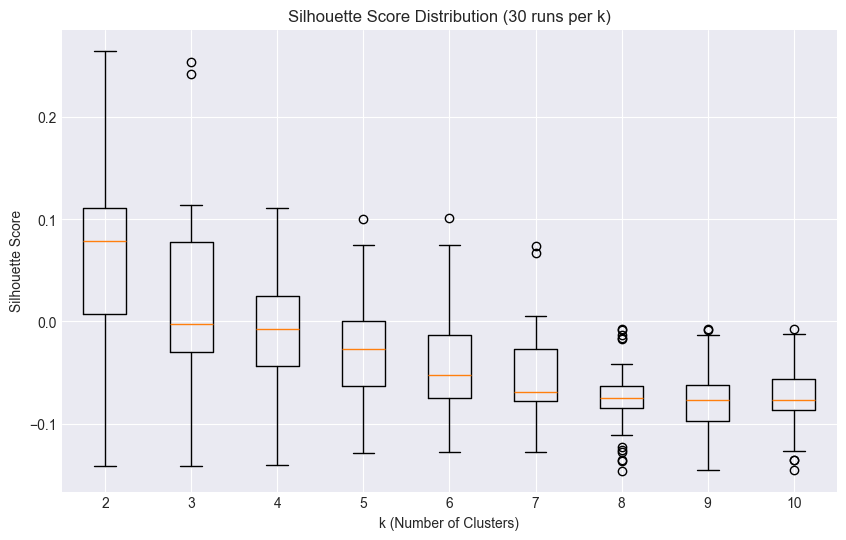

In [32]:
# K-Means clustering with multiple runs per k
silhouette_results = {k: [] for k in range(2, 11)}
best_models = {} # Store the best model for each k

for k in range(2, 11):
    best_k_score = -1
    
    for i in range(30):
        seed = i  # Fixed, uncorrelated seed
        # n_init=1 allows us to control the seed manually per run
        kmeans = KMeans(n_clusters=k, random_state=seed, n_init=1) 
        labels = kmeans.fit_predict(X_scaled)
        
        score = silhouette_score(X_scaled, labels)
        silhouette_results[k].append(score)
        
        # Keep the best run for this k
        if score > best_k_score:
            best_k_score = score
            best_models[k] = {'seed': seed, 'score': score, 'model': kmeans, 'labels': labels}

# Compute statistics
stats = pd.DataFrame([(k, np.mean(v), np.std(v), np.median(v)) 
                      for k, v in silhouette_results.items()], 
                     columns=['k', 'Mean', 'Std', 'Median'])

print(stats)

# Plot distribution (Boxplot)
plt.figure(figsize=(10, 6))
plt.boxplot(silhouette_results.values(), labels=silhouette_results.keys())
plt.title('Silhouette Score Distribution (30 runs per k)')
plt.xlabel('k (Number of Clusters)')
plt.ylabel('Silhouette Score')
plt.show()

## 3. Select the best k and the best seed
The value of k is chosen by comparing the **median Silhouette score** for all tested k values.
After selecting the k with the highest median, the run with the **maximum Silhouette score** inside that k is identified:
- Identify the row in the summary table with the highest median
- Extract that value of k
- Look up the list of 30 Silhouette scores for that k
- Select the seed corresponding to the maximum score

In [33]:
# Pick k with highest median Silhouette and the best run within it
best_k = stats.loc[stats['Median'].idxmax(), 'k']
best_run = best_models[best_k]

print(f"\nSelected k: {best_k} (Median: {stats.loc[stats['k']==best_k, 'Median'].values[0]:.4f})")
print(f"Best run for k={best_k}: Seed {best_run['seed']} with Score {best_run['score']:.4f}")


Selected k: 2 (Median: 0.0789)
Best run for k=2: Seed 23 with Score 0.2650


## 4. Cluster Feature Analysis (mean/std and heatmap)

Using the selected **k** and **seed**, k-Means is executed once more to obtain the final cluster labels.
To understand how clusters differ:
- Compute a **DataFrame** with mean and standard deviation of each scaled feature per cluster
- Visualize a **heatmap of cluster means**, showing which features contribute most to separation

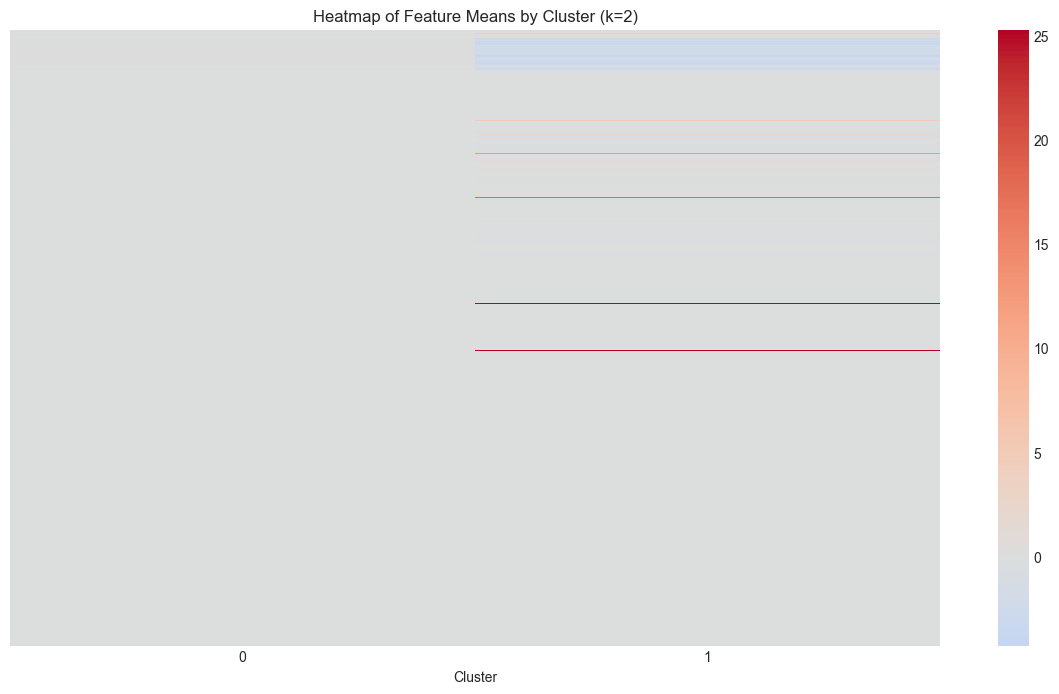

In [34]:
# Re-run k-Means with the selected k and seed
final_labels = best_run['labels']

# Create a dataframe for analysis
df_analysis = pd.DataFrame(X_scaled, columns=feature_names)
df_analysis['Cluster'] = final_labels

# i) Mean and Std per cluster
cluster_stats = df_analysis.groupby('Cluster').agg(['mean', 'std'])
# print(cluster_stats) # Optional: print to see values

# ii) Heatmap of cluster means
plt.figure(figsize=(15, 8))
# Transpose to put features on Y-axis, yticklabels=False hides the feature names
sns.heatmap(df_analysis.groupby('Cluster').mean().T, cmap='coolwarm', center=0, yticklabels=False)
plt.title(f'Heatmap of Feature Means by Cluster (k={best_k})')
plt.show()

## 5. PCA projection (PC1 & PC2) and 2D visualization

PCA is applied to the scaled feature matrix to reduce dimensionality.
The first two principal components (PC1 and PC2) are extracted and plotted in 2D, with points colored by cluster label.  

Steps:
- Fit PCA on the scaled data
- Extract PC1 and PC2
- Compute variance explained by each component
- Plot a 2D scatter colored by cluster assignments

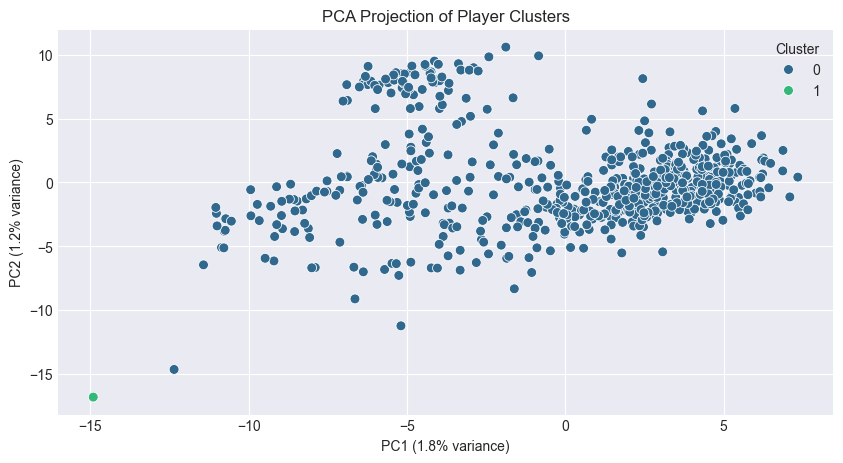

In [35]:
# Compute PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
var_explained = pca.explained_variance_ratio_

plt.figure(figsize=(10, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=final_labels, palette='viridis', s=50)

# Titles and labels
plt.title('PCA Projection of Player Clusters')
# Axis labels with variance explained
plt.xlabel(f'PC1 ({var_explained[0]:.1%} variance)')
plt.ylabel(f'PC2 ({var_explained[1]:.1%} variance)')
plt.legend(title='Cluster')
plt.show()

The PCA plot reveals a **trivial separation**: virtually all data points belong to a single massive cluster (Blue), while the second cluster (Green) consists of a **single isolated point**.

Technically, the clusters are "separable" (the distance between the single point and the main group is huge), but this does not represent two distinct player populations. Instead, K-Means has functioned as an **anomaly detector** here, isolating one outlier from the rest of the data.

This matches the feature analysis if the Heatmap showed one row with extreme values compared to the rest. However, this result is **not useful** for profiling player bases. It tells us we have one broken/strange record, but it fails to categorize the behaviors of the remaining 99% of players. A better approach would be to remove this outlier and re-run the clustering.

## 6. t-SNE visualization based on PCA-reduced data
t-SNE is applied to the 2D PCA representation to obtain a non-linear 2D projection.
This step verifies whether t-SNE provides a clearer visual separation of clusters than PCA.  

Steps:
- Use the previously computed X_pca
- Run t-SNE with fixed parameters for reproducibility
- Plot the 2D t-SNE embedding colored by clusters

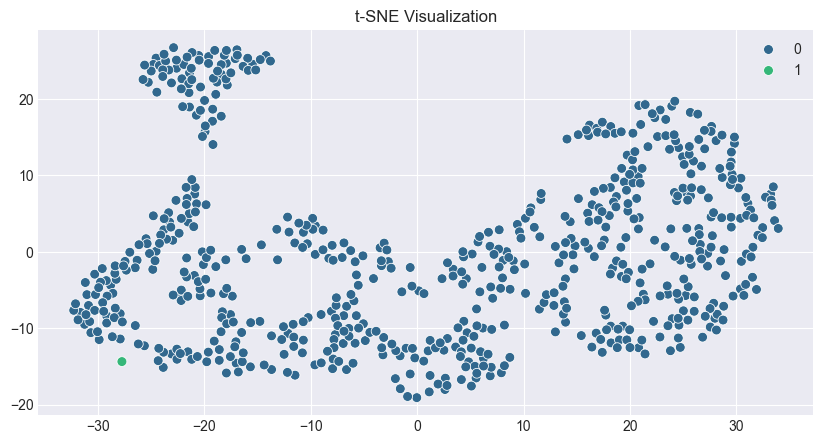

In [39]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_pca) 

plt.figure(figsize=(10, 5))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=final_labels, palette='viridis', s=50)
plt.title('t-SNE Visualization')
plt.show()

The t-SNE plot confirms exactly what we saw in the PCA: the structure is dominated by the distance between the main population (Cluster 0) and the single outlier (Cluster 1).

**Does t-SNE show the clusters more clearly?**

**No.** In this specific case, t-SNE does not offer an advantage over PCA.
PCA already showed that the outlier is linearly separable from the rest of the data with a massive margin. Since t-SNE tries to preserve local neighborhoods, it simply pushes the outlier far away again. It adds no new information because the "clustering" here is just simple anomaly detection, which the linear PCA handled well.

## 7. Bonus: PCA -> k-Means on PC1/PC2 and comparison

k-Means is now applied **only on PC1/PC2**, using the previously selected value of k.
Silhouette scores and visualizations (PCA and t-SNE) are compared with those obtained using all original features.  

Steps:
- Extract PC1/PC2 (X_pca)
- Run k-Means with the chosen best_k
- Compute Silhouette
- Plot PC1 vs PC2 colored by new clusters
- Compute t-SNE on PC1/PC2
- Plot t-SNE colored by new clusters
- Compare Silhouette values

Silhouette Score (Clusters defined via PCA): -0.0062
Compare with previous best score: 0.2650


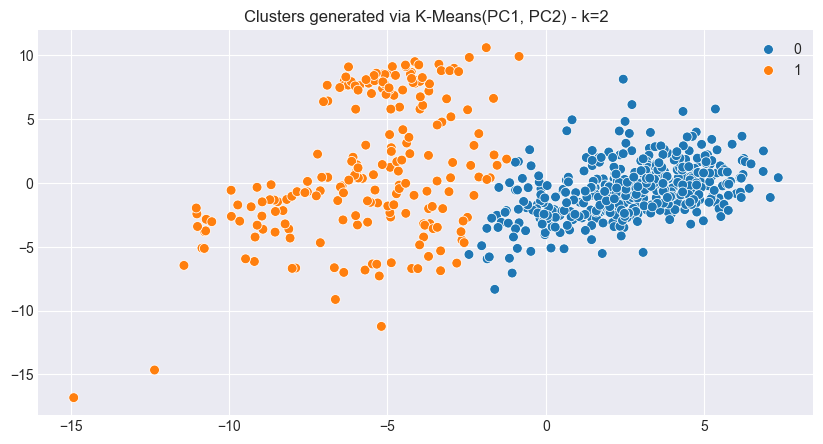

In [37]:
# K-Means clustering on PCA-reduced data
kmeans_pca = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels_pca_clusters = kmeans_pca.fit_predict(X_pca)

# Compute Silhouette Scores
score_orig = silhouette_score(X_scaled, labels_pca_clusters) # Evaluated on original features
score_pca_space = silhouette_score(X_pca, labels_pca_clusters) # Evaluated on PCA space

print(f"Silhouette Score (Clusters defined via PCA): {score_orig:.4f}")
print(f"Compare with previous best score: {best_run['score']:.4f}")

# Plot PCA-based clusters
plt.figure(figsize=(10, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels_pca_clusters, palette='tab10', s=50)
plt.title(f'Clusters generated via K-Means(PC1, PC2) - k={best_k}')
plt.show()

The clustering performed on the PCA-reduced data was **significantly worse**.
* **Original Score:** `0.2650` (Positive, indicating a structurally valid separation, albeit an outlier-based one).
* **PCA-based Score:** `-0.0062` (Negative).

A negative Silhouette score is a critical red flag. It indicates that data points have been assigned to the wrong cluster. In this specific case, the plot shows that K-Means simply sliced the main data blob in half (Blue vs. Orange) to satisfy $k=2$. The negative score confirms that this boundary is artificial and does not exist in the actual high-dimensional data.

**Why did PCA -> k-Means fail here?**

While PCA is generally excellent for removing noise and helping K-Means find compact groups, here it caused information loss. By projecting to 2D, we ignored the other dimensions that originally helped identify the true anomaly. We forced the algorithm to find a split in a dataset that likely doesn't have two balanced groups, resulting in an arbitrary division.

**How PCA helps in general**

In typical scenarios (unlike this specific run), PCA helps clustering by:

1. **Reducing the Curse of Dimensionality:** K-Means struggles with distance calculations in high dimensions, PCA focuses on the axes with the most information.
2. **Noise Reduction:** By dropping minor components, we often remove random noise that confuses the clustering algorithm.
3. **Visualization:** It allows us to visually verify if the clusters found by K-Means make geometric sense.